In [1]:
library(Seurat)
library(data.table)
library(ggplot2)
library(flexclust)

Attaching SeuratObject

Loading required package: grid

Loading required package: lattice

Loading required package: modeltools

Loading required package: stats4



In [2]:
datasetName = 'testis_testis_HCLFetalMaleGonad1'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/db_v1/testis_testis_HCLFetalMaleGonad1/")

In [3]:
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- read.table(paste0(datasetName,"_expression.tsv.gz"), h = T, row.names = 1)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}

In [4]:
data.matrix <- data.matrix[, -1]
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,FetalMaleGonad_1.CCGCTACTTCTGAACGCC,FetalMaleGonad_1.TACTTCACAATAACACCC,FetalMaleGonad_1.TCACTTTATGTAACGTTG,FetalMaleGonad_1.ACAATATAGTCGCCGACG,FetalMaleGonad_1.ATCAACGCCCTCTTCCGC
,<int>,<int>,<int>,<int>,<int>
A1CF,0,0,0,0,0
A2M,0,0,0,2,0
A2M-AS1,0,0,0,0,0
A2ML1,0,0,0,0,0
A4GALT,0,0,0,0,0


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
FetalMaleGonad_1.CTCGCAATCAACTGCAAT,Gonad,FetalMaleGonad,FetalMaleGonad,Healthy,Donor16,Male,GW12
FetalMaleGonad_1.CCGCTACTTCTGAACGCC,Gonad,FetalMaleGonad,FetalMaleGonad,Healthy,Donor16,Male,GW12
FetalMaleGonad_1.TACTTCACAATAACACCC,Gonad,FetalMaleGonad,FetalMaleGonad,Healthy,Donor16,Male,GW12
FetalMaleGonad_1.TCACTTTATGTAACGTTG,Gonad,FetalMaleGonad,FetalMaleGonad,Healthy,Donor16,Male,GW12
FetalMaleGonad_1.ACAATATAGTCGCCGACG,Gonad,FetalMaleGonad,FetalMaleGonad,Healthy,Donor16,Male,GW12


[1] "Primordial germ cell"                    
[2] "Immature sertoli cell (Pre-Sertoli cell)"
[3] "CB CD34+"                                
[4] "Erythroid progenitor cell (RP high)"     
[5] "Endothelial cell"

In [5]:
# Pre-processing
min.cells = 3
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

Warning message in CreateSeuratObject.default(counts = data.matrix, project = datasetName, :
“Some cells in meta.data not present in provided counts matrix”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


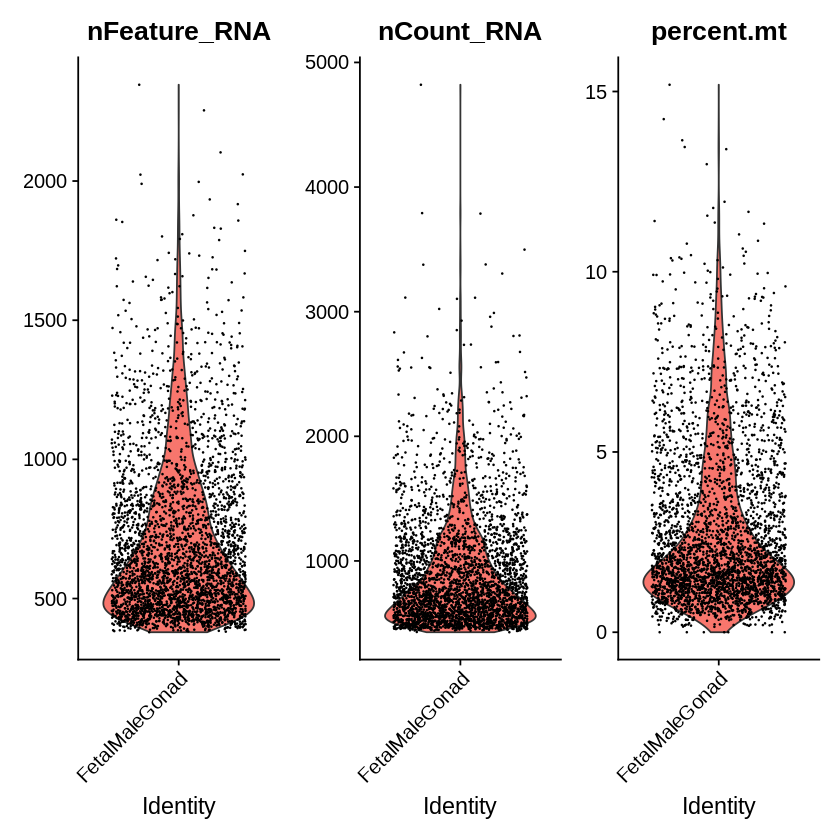

In [6]:
VlnPlot(dataobj, features = c('nFeature_RNA', 'nCount_RNA', 'percent.mt'), ncol = 3)

In [7]:
# QC
nFeature_RNA_range = c(200, 1500)
percent.mt.thre = 10
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)

In [8]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, selection.method = 'vst', nfeatures = 2000) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



In [9]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot

PC_ 1 
Positive:  AMH, MT-ND4, MT-ND3, MT-ND2, SERPINA5, MT-ATP6, APOA1, MIR202HG, GSTA1, ZFAND5 
	   CTSV, MT-CO3, MT-CYB, CKB, SERPINF1, BEX1, CITED1, TMEM123, INHA, RNASE1 
	   MT-RNR2, INHBB, CST3, SOX9, GATM, FATE1, REEP6, GADD45G, SUSD3, EGR1 
Negative:  COL3A1, COL1A1, MDK, TMSB4X, DCN, RPS18, GPC3, RPS14, RPL34, RPS6 
	   RPS27, OLFML3, RPL27A, ISLR, RPL13, RPL31, EEF1A1, MFAP4, CXCL12, RPL32 
	   FTL, DLK1, RPS3, TPM1, RPLP1, TGFBI, RPS29, TPM2, POSTN, CRABP2 
PC_ 2 
Positive:  COL1A1, COL3A1, DCN, OLFML3, ISLR, GPC3, CXCL12, DLK1, C7, MDK 
	   PKDCC, MATN2, BGN, RPS18, BST2, MFAP4, PCDH18, COL6A3, PDGFRA, POSTN 
	   PTCH1, NID1, TPM1, HIC1, NPW, HOXD9, TCF21, GAS1, COL5A1, RASL11B 
Negative:  SRGN, ARHGDIB, LYZ, TYROBP, MNDA, FCN1, CSTA, FCER1G, LAPTM5, RETN 
	   GMFG, ITGB2, ICAM3, S100A9, S100A8, CYBB, PLAC8, PRAM1, SPI1, S100A4 
	   ANXA1, HCST, TSPO, BPI, MS4A3, NKG7, AIF1, AZU1, LSP1, NCF2 
PC_ 3 
Positive:  SRGN, FCER1G, S100A9, TYROBP, LYZ, MNDA, FTL, ARHGDIB, LAPTM5, 

Warning message in ElbowPlot(dataobj, ndims = 100):
“The object only has information for 50 reductions”


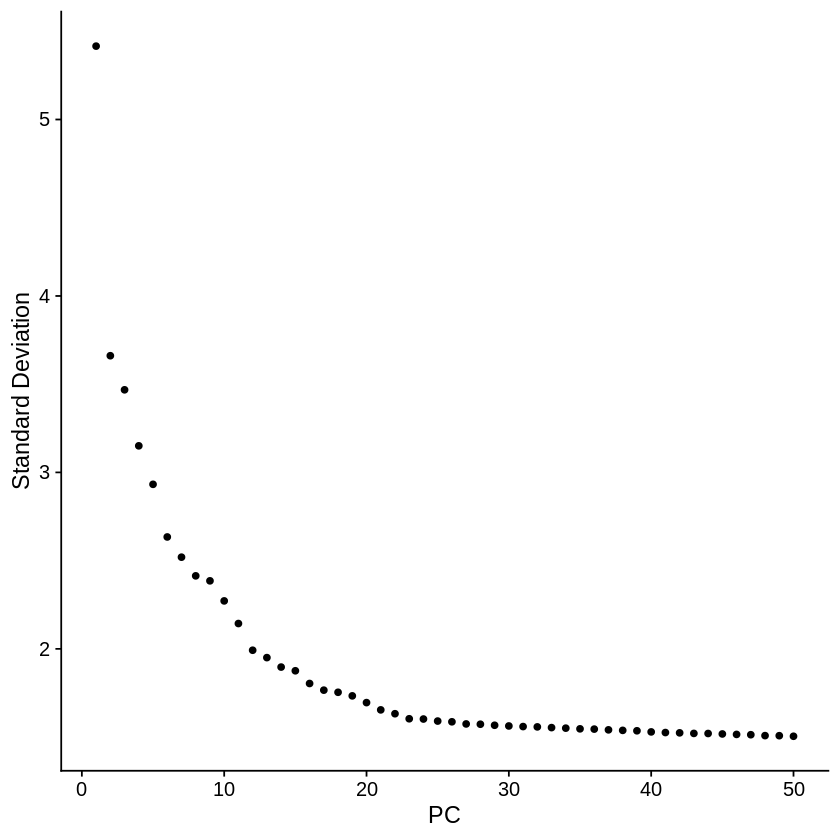

In [10]:
ElbowPlot(dataobj, ndims=100) 
# pdf(paste0(datasetName,"seurat.elbowplot.pdf"))

In [11]:
dev.off()
pcDim = 10 # set as 14 in this case 
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap", label = TRUE)
# ggsave(paste0(datasetName,".seurat.umap.tiff", plot = p_umap, width = 8, height = 5)

null device 
          1

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
16:35:07 UMAP embedding parameters a = 0.9922 b = 1.112

16:35:07 Read 3262 rows and found 10 numeric columns

16:35:07 Using Annoy for neighbor search, n_neighbors = 30

16:35:07 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:35:08 Writing NN index file to temp file /tmp/Rtmph2yKlj/file431762f9c6b5

16:35:08 Searching Annoy index using 1 thread, search_k = 3000

16:35:09 Annoy recall = 100%

16:35:09 Commencing smooth kNN distance calibration using 1 thread

16:35:09 Initializing fro

In [31]:
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 0.6)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3262
Number of edges: 114602

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8501
Number of communities: 12
Elapsed time: 0 seconds


16:40:28 UMAP embedding parameters a = 0.9922 b = 1.112

16:40:28 Read 3262 rows and found 10 numeric columns

16:40:28 Using Annoy for neighbor search, n_neighbors = 30

16:40:28 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:40:28 Writing NN index file to temp file /tmp/Rtmph2yKlj/file43172ce94a13

16:40:28 Searching Annoy index using 1 thread, search_k = 3000

16:40:29 Annoy recall = 100%

16:40:29 Commencing smooth kNN distance calibration using 1 thread

16:40:30 Initializing from normalized Laplacian + noise

16:40:30 Commencing optimization for 500 epochs, with 135034 positive edges

16:40:38 Optimization finished



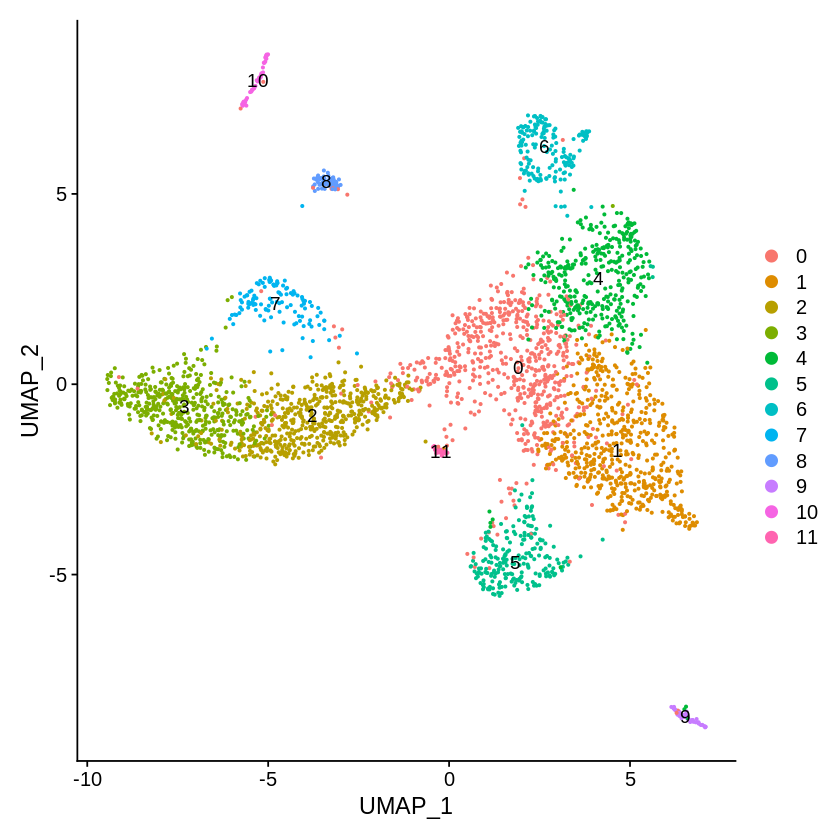

In [32]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [33]:
#ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

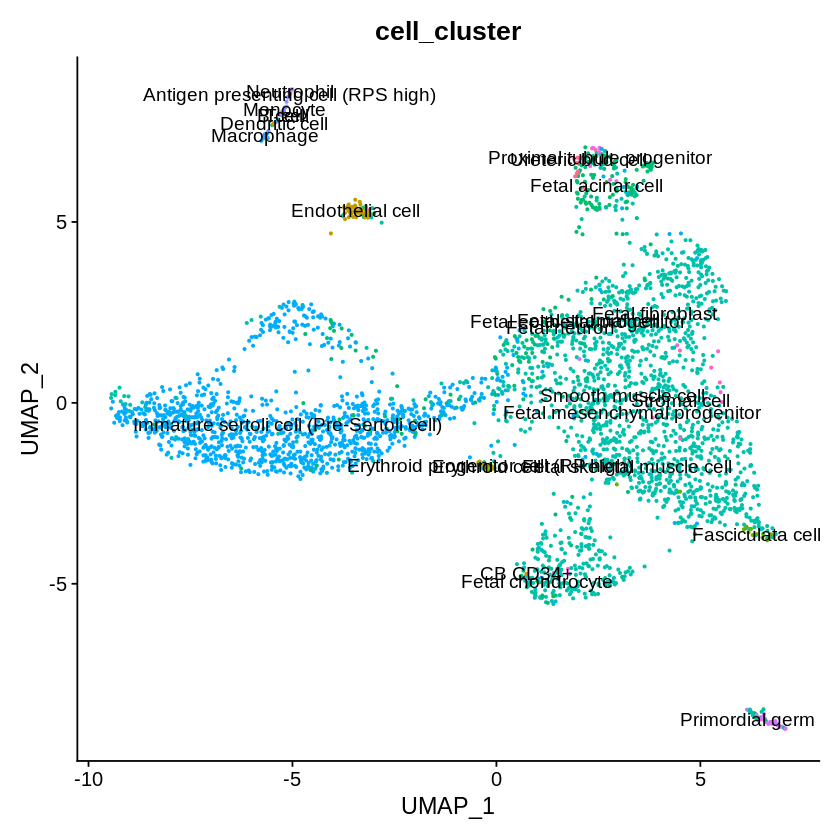

In [34]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster") + NoLegend()
p_umap2

In [16]:
#ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)

In [35]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".__seurat.markers.v1.1.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11



In [36]:
new.cluster.ids <- c("Testis-Epithelial tissue-Spermatogonial stem cell-POU5F1",
                     "Testis-Connective tissue-Fasciculata cell-INSL3",
                     "Testis-Epithelial tissue-Differentiating spermatogonia-UBE2C HMGB2 CDK1",
                     "Testis-Epithelial tissue-Sertoli cell-AMH",
                     "Testis-Connective tissue-Mesenchymal stromal cell-DCN CXCL12 DLK1",
                     "Testis-Connective tissue-Neutrophilic granulocyte-SULT1E1 COL3A1 LGALS1",
                     "Testis-Epithelial tissue-Acinar cell-CD24 CLDN3",
                     "Testis-Epithelial tissue-Differentiated spermatogonia-BNC1",
                     "Testis-Epithelial tissue-Endothelial cell-SOX18 PECAM1 CD34",
                     "Unclassified",
                     "Testis-Connective tissue-Monocyte/Neutrophilic granulocyte-FCN1 FCER1G/TYROBP",
                     "Testis-Connective tissue-Erythrocyte-HBA1 HBG2 HBA2"
                    )
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

In [37]:
#ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [38]:
#saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

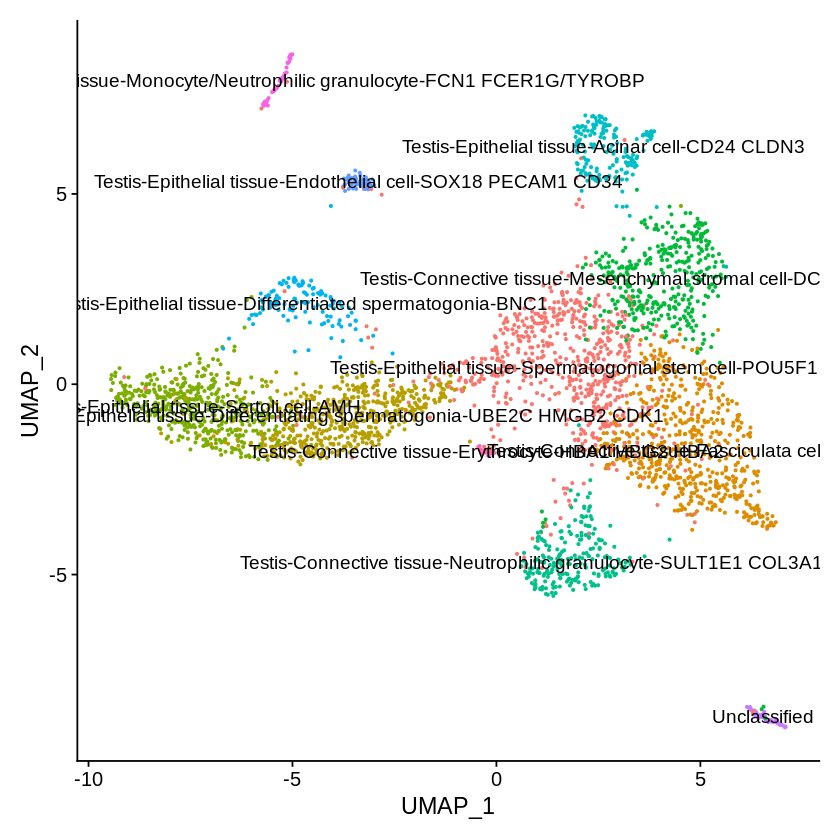

In [39]:
pp_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE)+ NoLegend()
pp_umap2

In [79]:
#saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))